## <u>Cuckoo Filter</u>
### Maggie Drew & Adam Gibbs

Implementation of Cuckoo Filter for estimating set membership on data streams. Implementation psuedocode from the following paper: https://www.cs.cmu.edu/~dga/papers/cuckoo-conext2014.pdf. This document also helped with figuring out Partial-Kay Cuckoo Hashing: https://williams-cs.github.io/cs358-s20/lectures/lecture10/bloom.pdf. This notebook contains the following:

1. Imports used in the notebook
2. All global variables and python data structures (lists, dictionaries, etc.) used
3. Code for Cuckoo Filter functions
4. Cuckoo filter test on simulated data stream
5. Results
6. Analysis of Results 

In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import gzip
import random
import math
import time
import polyhash

# uncomment if library is needed
# !{sys.executable} -m pip install mmh3
import mmh3


In [2]:
# # VARIABLES and DATA STRUCTURES

# # dataset to be used as data stream
# nytimes = './vocab.nytimes.txt'
# small_nytimes = './small.nytimes.txt'
# test_input = './input.txt'

# # number of buckets in hash table
# bucket_size = 10000
# # number of fingerprints in each bucket
# entries_per_bucket = 4

# # fingerprint size (in bits)
# fingerprint_size = 2




In [3]:
# Class containing basic Cuckoo Filter with insert, lookup, and delete functionality
# Creates a Cuckoo Filter with buckets_size buckets
# Each bucket has depth 1 and is initialized to NaN to start
# Uses mmh3 for hash function, so elements passed into functions should be strings
#    however, the element will be cast to a string, so as long as element can be a string you're good

class CuckooFilter():

    # CONSTRUCTOR
    def __init__(self, bucket_size, fingerprint_size=10, k=5):
        # calculate the mod value for fingerprint
        self.fingerprint_mod = 2**(fingerprint_size)
        # store value specifying length of array
        self.bucket_size = bucket_size
        # make a filter of specified size
        self.buckets = np.empty(bucket_size)
        # initialize all elements to be null
        # we use np.NaN for easy use
        self.buckets.fill(np.NaN)
        '''
        self.coefficients = []
        for i in range(0,k):
            self.coefficients.append(random.uniform(0,7919))
        '''
    
    # HELPER METHODS

    # creates fingerprint for element in datastream]
    # creates a fingerprint of fingerprint_size bits
    # bits get stored as integer by taking a hash mod 2^fingerprint_size 
    def create_fingerprint(self, x):
        return mmh3.hash(str(x),5) % self.fingerprint_mod

    # defines our first hash function
    # use mmh3 hash with seed set to 1
    def hash1(self, x):
        return mmh3.hash(str(x),1) % self.bucket_size

    # defines our second hash function
    # this is used to hash fingerprints for alternate bucket
    # use mmh3 hash with seed set to 2
    def hash2(self, x):
        return mmh3.hash(str(x),2) % self.bucket_size

    '''
    def k_ind_hash(self, x):
        hash_val = self.coefficients[0]
        for i in range(1, len(self.coefficients)):
            hash_val += self.coefficients[i]*math.pow(int(x),i)
        return round(hash_val) % self.bucket_size
    '''
        

    # method used to relocate entries when an incoming element has no free bucket
    # returns true if all old buckets are successfully relocated
    # returns false if all buckets are filled
    def relocate(self, f, bucket):

        count = 0
        while count < len(self.buckets):

            bucket = (bucket ^ self.hash2(int(f))) % self.bucket_size

            if pd.isnull(self.buckets[bucket]): 
                self.buckets[bucket] = f
                return True
            else:
                old = self.buckets[bucket]
                self.buckets[bucket] = f
                f = old
            count += 1
        
        return False
    
    # CORE METHODS - insert, lookup, and delete

    # method used to insert an element
    # returns true if the element is inserted
    #    or returns true if element has already been inserted
    # returns false if the element is not inserted
    def insert(self, x):

        # get fingerprint for element
        f = self.create_fingerprint(x)

        # find two hash function values
        # second hash function is... 
        # [hash_func(x) xor fingerprint(x)] % bucket_size
        h1 = self.hash1(x)
        h2 = (h1 ^ self.hash2(f)) % self.bucket_size

        # if first bucket is empty or x is already in it,,, add f and return true
        # elif second bucket is empty or x is already in it,,, add f and return true
        # else randomly pick bucket 1 or 2, then,
        # add f to that bucket and relocate the value it replaces, 
        #    if relocation is successful,,, return true
        #    if relocation is not successful,,, undo changes to buckets and return false
        if pd.isnull(self.buckets[h1]) or self.buckets[h1] == f:
            self.buckets[h1] = f
            return True
        elif pd.isnull(self.buckets[h2]) or self.buckets[h2] == f:
            self.buckets[h2] = f
            return True
        else:
            rand_num = random.random()
            if rand_num < 0.5:
                # store buckets in case relocation is unsuccessful
                old_buckets = np.copy(self.buckets)
                # swap fingerprint with current entry
                old = self.buckets[h1]
                self.buckets[h1] = f
                # relocate current entry
                added = self.relocate(old, h1)
                
                # if relocation is unsuccessful, restore buckets return false
                if not added:
                    self.buckets = old_buckets
                    return added
                else:
                    return added
            else:
                # store buckets in case relocation is unsuccessful
                old_buckets = np.copy(self.buckets)
                # swap fingerprint with current entry
                old = self.buckets[h2]
                self.buckets[h2] = f
                # relocate current entry
                added = self.relocate(old, h2)
                
                # if relocation is unsuccessful, restore buckets return false
                if not added:
                    self.buckets = old_buckets
                    return added
                else:
                    return added

    # method used to determine if an element is in the filter
    # gets the fingerprint and calcuates the hash functions, then 
    # if element is in first or second bucket,,, return true
    # otherwise,,, return false
    def lookup(self, x):
        # get fingerprint
        f = self.create_fingerprint(x)

        # get two possible buckets for element
        h1 = self.hash1(x)
        h2 = (h1 ^ self.hash2(f)) % self.bucket_size

        # if element's fingerprint is stored in either bucket,,, return true
        # otherwise,,, return false
        if self.buckets[h1] == f or self.buckets[h2] == f:
            return True
        else:
            return False

    # method used to delete an element in the filter
    # gets the fingerprint and calcuates the hash functions, then 
    # if element is in first bucket, put a NaN in that bucket,,, return true 
    # if element is in second bucket, put a NaN in that bucket,,, return true 
    # otherwise element was not in filter,,, return false
    def delete(self, x):
        # get fingerprint of the element
        f = self.create_fingerprint(x)

        # get two possible buckets of the element
        h1 = self.hash1(x)
        h2 = (h1 ^ self.hash2(f)) % self.bucket_size

        # if element is in first bucket, 
        # make that value null (np.NaN),,, return true
        # else if element is in second bucket,
        # make that value null (np.NaN),,, return true
        if self.buckets[h1] == f:
            self.buckets[h1] = np.NaN
            return True
        elif self.buckets[h2] == f:
            self.buckets[h2] = np.NaN
            return True
        
        # if element was not in either bucket, it is not in the filter,
        # thus it cannot be deleted,,, return false
        return False


In [8]:
# Class containing Extended Cuckoo Filter with insert, lookup, and delete functionality
# Creates a Cuckoo Filter with buckets_size buckets that each contain entries_per_bucket fingerprints
# Each bucket has depth 1 and is initialized to NaN to start
# Uses mmh3 for hash function, so elements passed into functions should be strings
#    however, the element will be cast to a string, so as long as element can be a string you're good

class ExtendedCuckooFilter():


    # CONSTRUCTOR
    def __init__(self, bucket_size, entries_per_bucket, fingerprint_size=10, k=5):
        # calculate the mod value for fingerprint
        self.fingerprint_mod = 2**(fingerprint_size)
        # store values specifying shape of array
        self.bucket_size = bucket_size
        self.entries_per_bucket = entries_per_bucket
        # make a 2D array of length bucket_size 
        # of arrays of length entries_per_bucket
        self.buckets = np.empty((bucket_size, entries_per_bucket))
        # initialize all elements to be null
        # we use np.NaN for easy use
        self.buckets.fill(np.NaN)
        '''
        self.coefficients = []
        for i in range(0,k):
            self.coefficients.append(random.uniform(0,7919))
        '''
    
    # HELPER METHODS

    # creates fingerprint for element in datastream]
    # creates a fingerprint of fingerprint_size bits
    # bits get stored as integer by taking a hash mod 2^fingerprint_size 
    def create_fingerprint(self, x):
        return mmh3.hash(str(x),5) % self.fingerprint_mod

    # defines our first hash function
    # use mmh3 hash with seed set to 1
    def hash1(self, x):
        return mmh3.hash(str(x),1) % self.bucket_size
        #return polyhash.generatePolyhash(str(x), self.bucket_size)

    # defines our second hash function
    # this is used to hash fingerprints for alternate bucket
    # use mmh3 hash with seed set to 2
    def hash2(self, x):
        return mmh3.hash(str(x),2) % self.bucket_size

    '''
    def k_ind_hash(self, x):
        hash_val = self.coefficients[0]
        for i in range(1, len(self.coefficients)):
            hash_val += self.coefficients[i]*math.pow(int(x),i)
        return round(hash_val) % self.bucket_size
    '''

    # method used to relocate entries when an incoming element has no free bucket
    # returns true if all old buckets are successfully relocated
    # returns false if all buckets are filled
    def relocate(self, f, bucket):

        count = 0
        while count < 5000:
            
            # get alternate bucket 
            bucket = (bucket ^ self.hash2(int(f))) % self.bucket_size

            # check all entries in each bucket,
            # if an entry is empty, add f
            for i in range(0, self.entries_per_bucket):
                if pd.isnull(self.buckets[bucket][i]): 
                    self.buckets[bucket][i] = f
                    return True
            
            # if entire bucket is filled,
            # randomly swap f with an entry and,
            # repeat relocation process with removed entry
            randIndex = random.randint(0,self.entries_per_bucket-1)
            old = self.buckets[bucket][randIndex]
            self.buckets[bucket][randIndex] = f
            f = old

            # increment count
            count += 1
        
        # if we looped through all buckets and entry cannot be added,
        # return false because bucket is too full
        return False
    

    # CORE METHODS - insert, lookup, and delete

    # method used to insert an element
    # returns true if the element is inserted
    #    or returns true if element has already been inserted
    # returns false if the element is not inserted
    def insert(self, x):

        # get fingerprint for element
        f = self.create_fingerprint(x)

        # find two hash function values
        # second hash function is... 
        # [hash1(x) xor hash2(fingerprint(x))] % bucket_size
        h1 = self.hash1(x)
        h2 = (h1 ^ self.hash2(f)) % self.bucket_size

        # if first bucket is empty or x is already in it,,, add f and return true
        # elif second bucket is empty or x is already in it,,, add f and return true
        # else randomly pick bucket 1 or 2, then,
        # add f to that bucket and relocate the value it replaces, 
        #    if relocation is successful,,, return true
        #    if relocation is not successful,,, undo changes to buckets and return false
        for i in range(0, self.entries_per_bucket):
            if pd.isnull(self.buckets[h1][i]) or self.buckets[h1][i] == f:
                self.buckets[h1][i] = f
                return True
        for i in range(0, self.entries_per_bucket):
            if pd.isnull(self.buckets[h2][i]) or self.buckets[h2][i] == f:
                self.buckets[h2][i] = f
                return True
        
        rand_num = random.random()
        if rand_num < 0.5:
            # store buckets in case relocation is unsuccessful
            old_buckets = np.copy(self.buckets)
            # pick random entry
            randIndex = random.randint(0,self.entries_per_bucket-1)
            # swap fingerprint with random entry
            old = self.buckets[h1][randIndex]
            self.buckets[h1][randIndex] = f
            # relocate randomly removed entry
            added = self.relocate(old, h1)
            
            # if relocation is unsuccessful, restore buckets return false
            if not added:
                self.buckets = old_buckets
                return added
            else:
                return added
        else:
            # store buckets in case relocation is unsuccessful
            old_buckets = np.copy(self.buckets)
            # pick random entry
            randIndex = random.randint(0,self.entries_per_bucket-1)
            # swap fingerprint with random entry
            old = self.buckets[h2][randIndex]
            self.buckets[h2][randIndex] = f
            # relocate randomly removed entry
            added = self.relocate(old, h2)
            
            # if relocation is unsuccessful, restore buckets return false
            if not added:
                self.buckets = old_buckets
                return added
            else:
                return added

    # method used to determine if an element is in the filter
    # gets the fingerprint and calcuates the hash functions, then 
    # if element is in first or second bucket,,, return true
    # otherwise,,, return false
    def lookup(self, x):
        # get fingerprint of element
        f = self.create_fingerprint(x)

        # get two possible buckets
        h1 = self.hash1(x)
        h2 = (h1 ^ self.hash2(f)) % self.bucket_size

        # if the element's fingerprint is an entry in either bucket,,, return true
        for i in range(0, self.entries_per_bucket):
            if self.buckets[h1][i] == f or self.buckets[h2][i] == f:
                return True
        return False

    # method used to delete an element in the filter
    # gets the fingerprint and calcuates the hash functions, then 
    # if element is in first bucket, put a NaN in that bucket,,, return true 
    # if element is in second bucket, put a NaN in that bucket,,, return true 
    # otherwise element was not in filter,,, return false
    def delete(self, x):
        # get fingerprint of element
        f = self.create_fingerprint(x)

        # get two possible buckets
        h1 = self.hash1(x)
        h2 = (h1 ^ self.hash2(f)) % self.bucket_size

        # element can only be in one of the buckets, 
        # check first bucket first
        # loop through first bucket and if element's fingerprint is an entry
        # make that entry value null (np.NaN in this implementation)
        for i in range(0, self.entries_per_bucket):
            if self.buckets[h1][i] == f:
                self.buckets[h1][i] = np.NaN
                return True

        # now loop through second bucket and if element's fingerprint is an entry
        # make that entry value null (np.NaN in this implementation)
        for i in range(0, self.entries_per_bucket):
            if self.buckets[h2][i] == f:
                self.buckets[h2][i] = np.NaN
                return True
        
        # if element wasn't found as an entry in either bucket,
        # then it cannot be deleted,,, return false
        return False


In [11]:
# READ IN DATA AND APPLY FILTER

cf = ExtendedCuckooFilter(30, 2)

with open('input.txt', 'rt') as data_stream:
    for line in data_stream:
        for element in line.split():
            print("Insert " + str(element) + "? " + str(cf.insert(element)) + 
                  "\nfingerprint(" + str(element) + ")=" + " " + str(cf.create_fingerprint(element)) + '\n')
print("\nFilter: \n" + str(cf.buckets) + "\n")

# lookup every element that is added to the filter
# return true is expected as Cuckoo Filters have no false negatives
with open(test_input, 'rt') as data_stream:
    for line in data_stream:
        for element in line.split():
            if not cf.lookup(element):
                print("Lookup " + str(element) + "? " + str(cf.lookup(element)))

print()
print("Lookup Test")

# lookup 5 values that were not inserted into the filter
# return false expected, but there could be false positives
# however, false positives will such a low number of insertions are rare
for test in ['36', '75', '3', '0', '101']:
    print("Lookup " + str(test) + "? " + str(cf.lookup(test)))

print()
print("Deletion Test")
# delete 3 elements that are in the filter
# return true expected
print('Delete ' + '5? ' + str(cf.delete('5')))
print('Delete ' + '33? ' + str(cf.delete('33')))
print('Delete ' + '77? ' + str(cf.delete('77')))
# delete an element that is not in the filter
# return false expected
print('Delete ' + '55?' + str(cf.delete('55')))

print()

# see if any deleted elements remain in the filter
# return false expected every time
print("Lookup " + '5? ' + str(cf.lookup('5')))
print("Lookup " + '33? ' + str(cf.lookup('33')))
print("Lookup " + '77? ' + str(cf.lookup('77')))
print("Lookup " + '55? ' + str(cf.lookup('55')))

Insert 5? True
fingerprint(5)= 743

Insert 4? True
fingerprint(4)= 475

Insert 9? True
fingerprint(9)= 529

Insert 11? True
fingerprint(11)= 396

Insert 33? True
fingerprint(33)= 919

Insert 46? True
fingerprint(46)= 30

Insert 77? True
fingerprint(77)= 927

Insert 13? True
fingerprint(13)= 588

Insert 42? True
fingerprint(42)= 278

Insert 155? True
fingerprint(155)= 616

Insert 207? True
fingerprint(207)= 677

Insert 999? True
fingerprint(999)= 92


Filter: 
[[396.  nan]
 [ nan  nan]
 [278.  nan]
 [677.  nan]
 [743.  nan]
 [ nan  nan]
 [ nan  nan]
 [529.  nan]
 [ nan  nan]
 [475. 588.]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ 30.  nan]
 [ nan  nan]
 [ nan  nan]
 [616.  nan]
 [ nan  nan]
 [ nan  nan]
 [927.  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [ nan  nan]
 [919.  92.]
 [ nan  nan]
 [ nan  nan]]



NameError: name 'test_input' is not defined

In [13]:
# READ IN DATA AND APPLY FILTER

cf2 = ExtendedCuckooFilter(20000, 3)

print("Insertion Test")

not_inserted = 0
with open('small.nytimes.txt', 'rt') as data_stream:
    for line in data_stream:
        for element in line.split():
            if not cf2.insert(element):
                not_inserted += 1
                print("Insert " + str(element) + "? False")

if not_inserted == 0:
    print("All values sucessfully inserted!")

print("\nFilter: \n" + str(cf2.buckets) + '\n')

print("Lookup Test")

# lookup every element that is added to the filter
# return true is expected as Cuckoo Filters have no false negatives
absent = 0
with open('small.nytimes.txt', 'rt') as data_stream:
    for line in data_stream:
        for element in line.split():
            if not cf2.lookup(element):
                absent += 1
                print("Lookup " + str(element) + "? False")
if absent == 0:
    print("All values checked were in the filter. No false negatives!")

print()
print("Deletion Test")
# delete 3 elements that are in the filter
# return true expected
print('Delete abortion? ' + str(cf2.delete('abortion')))
# delete an element that is not in the filter
# return false expected
print('Delete mirror? ' + str(cf2.delete('mirror')))

print()

# see if any deleted elements remain in the filter
# return false expected every time
print('Lookup abortion? ' + str(cf2.lookup('abortion')))
print('Lookup mirror? ' + str(cf2.lookup('mirror')))

Insertion Test
All values sucessfully inserted!

Filter: 
[[ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan  nan]
 ...
 [ 51.  nan  nan]
 [891.  nan  nan]
 [ nan  nan  nan]]

Lookup Test
All values checked were in the filter. No false negatives!

Deletion Test
Delete abortion? False
Delete mirror? True

Lookup abortion? False
Lookup mirror? False


In [14]:

cfe2 = ExtendedCuckooFilter(300000, 5)

count = 0
added = 0
not_added = 0


with open('vocab.nytimes.txt', 'rt') as data_stream:
    start_time = time.time()
    for line in data_stream:
        for element in line.split():
            count += 1
            add = cfe2.insert(element)
            if add:
                added += 1
            else:
                not_added += 1

end_time = time.time() - start_time
print(end_time)

print("Total insertions: " + str(count))
print("Successful Insertions (including entries already added): " + str(added))
print("Unsuccessful Insertions: " + str(not_added))
print("Average insertion time: " + str(round(end_time * 1000 / count, 5)) + str("ms"))

0.4224088191986084
Total insertions: 102660
Successful Insertions (including entries already added): 102660
Unsuccessful Insertions: 0
Average insertion time: 0.00411ms


# Experiments performed on NYTimes Bag of Words Dataset

1. False Positive Rate vs Size of Fingerprint
2. False Positive Rate vs Bits Per Entry
3. False Positive Rate vs Number of Entries Per Bucket

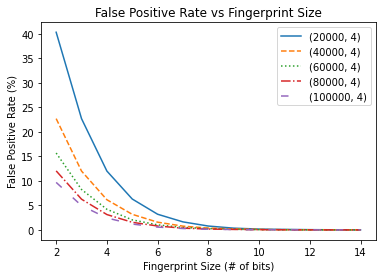

In [27]:
entries = 4
sizes = [20000, 40000, 60000, 80000, 100000]
outputs = [[], [], [], [], []]

index = 0
for size in sizes:
    for f_size in range(2,15):
        cfe = ExtendedCuckooFilter(size, entries, f_size)

        with open('insert2.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                    cfe.insert(element)

        false_pos = 0
        checked = 0
        with open('lookup2.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                    checked += 1
                    if cfe.lookup(element):
                        false_pos += 1    
        
        outputs[index].append(round(false_pos * 100 / checked, 4))

    index += 1


# styles for line graph lines
line_styles = ["solid", "dashed", "dotted", "dashdot", (0, (5, 10))]

for i in range(0,5):
    plt.plot(range(2,15), outputs[i], label='('+str(sizes[i])+', '+str(entries)+')', linestyle=line_styles[i])

plt.title("False Positive Rate vs Fingerprint Size")
plt.xlabel("Fingerprint Size (# of bits)")
plt.ylabel("False Positive Rate (%)")
plt.legend()

plt.show()    


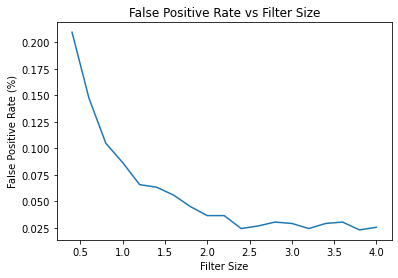

In [26]:
entries = 4
sizes = range(20000, 210000, 10000)
outputs = []

for size in sizes:

    cfe = ExtendedCuckooFilter(size, entries)

    with open('insert2.txt', 'rt') as data_stream:
        for line in data_stream:
            for element in line.split():
                cfe.insert(element)

    false_pos = 0
    checked = 0
    with open('lookup2.txt', 'rt') as data_stream:
        for line in data_stream:
            for element in line.split():
                checked += 1
                if cfe.lookup(element):
                    false_pos += 1     
    
    outputs.append(round(false_pos * 100 / checked, 4))

bpe = []
for size in sizes:
    b = 500000 / size
    bpe.append((10/b))

plt.plot(bpe, outputs)

plt.title("False Positive Rate vs Bits Per Entry")
plt.xlabel("Filter Size")
plt.ylabel("False Positive Rate (%)")

plt.show()

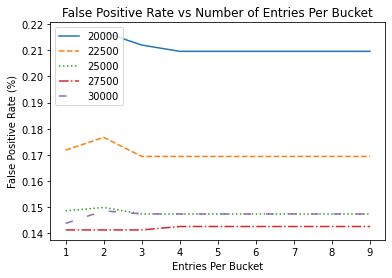

In [33]:
sizes = [20000, 22500, 25000, 27500, 30000]
entries = range(1,10)
outputs = [[],[],[],[],[]]

index = 0
for size in sizes:
    for entry in entries:
    
        if size == 20000 and entry == 1:
            outputs[index].append(np.NaN)
            continue

        cfe = ExtendedCuckooFilter(size, entry)

        with open('insert2.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                    cfe.insert(element)

        false_pos = 0
        checked = 0
        with open('lookup2.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                    checked += 1
                    if cfe.lookup(element):
                        false_pos += 1    

        outputs[index].append(round(false_pos * 100 / checked, 4))
    index += 1

# styles for line graph lines
line_styles = ["solid", "dashed", "dotted", "dashdot", (0, (5, 10))]

for i in range(0,len(sizes)):
    plt.plot(entries, outputs[i], label=str(sizes[i]), linestyle=line_styles[i])

plt.title("False Positive Rate vs Number of Entries Per Bucket")
plt.xlabel("Entries Per Bucket")
plt.ylabel("False Positive Rate (%)")
plt.legend()

plt.show()

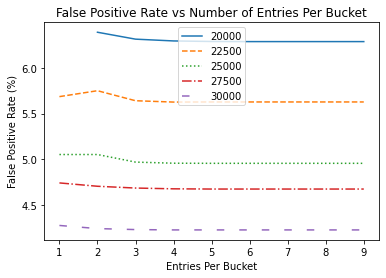

In [34]:
sizes = [20000, 22500, 25000, 27500, 30000]
entries = range(1,10)
f_size = 5
outputs = [[],[],[],[],[]]

index = 0
for size in sizes:
    for entry in entries:
    
        if size == 20000 and entry == 1:
            outputs[index].append(np.NaN)
            continue

        cfe = ExtendedCuckooFilter(size, entry,fingerprint_size=f_size)

        with open('insert2.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                    cfe.insert(element)

        false_pos = 0
        checked = 0
        with open('lookup2.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                    checked += 1
                    if cfe.lookup(element):
                        false_pos += 1    

        outputs[index].append(round(false_pos * 100 / checked, 4))
    index += 1

# styles for line graph lines
line_styles = ["solid", "dashed", "dotted", "dashdot", (0, (5, 10))]

for i in range(0,len(sizes)):
    plt.plot(entries, outputs[i], label='('+str(sizes[i])+', f='+str(f_size)+')', linestyle=line_styles[i])

plt.title("False Positive Rate vs Number of Entries Per Bucket")
plt.xlabel("Entries Per Bucket")
plt.ylabel("False Positive Rate (%)")
plt.legend()

plt.show()

# Experiments Performed on Random Dataset of Integers
 
1. False Positive Rate vs Size of Fingerprint
2. False Positive Rate vs Bits Per Entry
3. False Positive Rate vs Number of Entries Per Buckets
4. Time to Add 500,000 Elements to Filter vs Number of Entries Per Buckets
5. Time to Add 500,000 Elements to Filter vs Number of Buckets

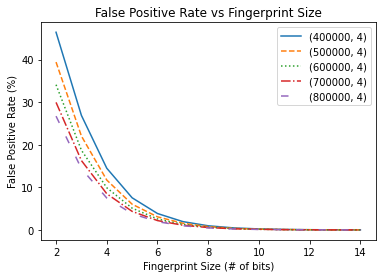

In [12]:

sizes = [400000, 500000, 600000, 700000, 800000]
outputs = [[], [], [], [], []]

index = 0
for size in sizes:
    for f_size in range(2,15):

        cf = ExtendedCuckooFilter(size, 4, f_size)

        with open('insert.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                        cf.insert(element)

        false_pos = 0
        checked = 0
        with open('lookup.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                        checked += 1
                        if cf.lookup(element):
                            false_pos += 1 
        
        outputs[index].append(round(false_pos * 100 / checked, 4))

    index += 1


# styles for line graph lines
line_styles = ["solid", "dashed", "dotted", "dashdot", (0, (5, 10))]

for i in range(0,5):
    plt.plot(range(2,15), outputs[i], label='('+str(sizes[i])+', '+str(4)+')', linestyle=line_styles[i])

plt.title("False Positive Rate vs Fingerprint Size")
plt.xlabel("Fingerprint Size (# of bits)")
plt.ylabel("False Positive Rate (%)")
plt.legend()

plt.show()    


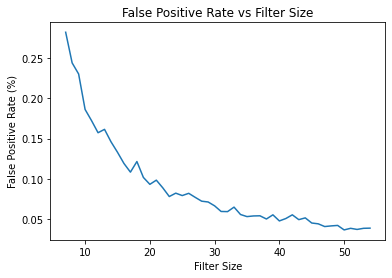

In [25]:
f_size = 7
sizes = range(350000, 2750000, 50000)
outputs = []

for size in sizes:

    cf = ExtendedCuckooFilter(size, 4, f_size)

    with open('insert.txt', 'rt') as data_stream:
        for line in data_stream:
            for element in line.split():
                    cf.insert(element)

    false_pos = 0
    checked = 0
    with open('lookup.txt', 'rt') as data_stream:
        for line in data_stream:
            for element in line.split():
                    checked += 1
                    if cf.lookup(element):
                        false_pos += 1  
    
    outputs.append(round(false_pos * 100 / checked, 4))

bpe = []
for size in sizes:
    b = 500000 / size
    bpe.append((f_size/b))

plt.plot(bpe, outputs)

plt.title("False Positive Rate vs Bits Per Entry")
plt.xlabel("Filter Size")
plt.ylabel("False Positive Rate (%)") 

plt.show()

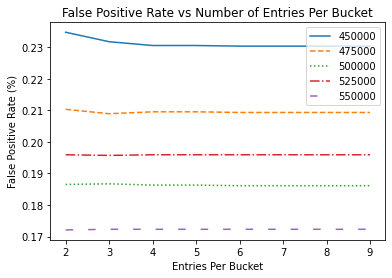

In [37]:
sizes = range(450000,575000,25000)
entries = range(2,10)
outputs = [[],[],[],[],[]]

index = 0
for size in sizes:
    for entry in entries:

        cf = ExtendedCuckooFilter(size, entry)

        with open('insert.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                        cf.insert(element)

        false_pos = 0
        checked = 0
        with open('lookup.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                        checked += 1
                        if cf.lookup(element):
                            false_pos += 1 

        outputs[index].append(round(false_pos * 100 / checked, 4))
    index += 1

# styles for line graph lines
line_styles = ["solid", "dashed", "dotted", "dashdot", (0, (5, 10))]

for i in range(0,len(sizes)):
    plt.plot(entries, outputs[i], label=str(sizes[i]), linestyle=line_styles[i])

plt.title("False Positive Rate vs Number of Entries Per Bucket")
plt.xlabel("Entries Per Bucket")
plt.ylabel("False Positive Rate (%)")
plt.legend()

plt.show()

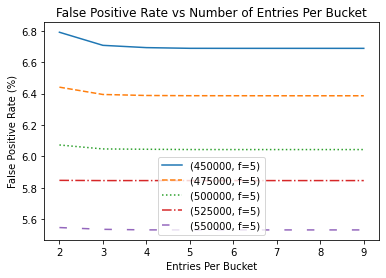

In [38]:
f_size = 5
sizes = range(450000,575000,25000)
entries = range(2,10)
outputs = [[],[],[],[],[]]

index = 0
for size in sizes:
    for entry in entries:

        cf = ExtendedCuckooFilter(size, entry, fingerprint_size=f_size)

        with open('insert.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                        cf.insert(element)

        false_pos = 0
        checked = 0
        with open('lookup.txt', 'rt') as data_stream:
            for line in data_stream:
                for element in line.split():
                        checked += 1
                        if cf.lookup(element):
                            false_pos += 1 

        outputs[index].append(round(false_pos * 100 / checked, 4))
    index += 1

# styles for line graph lines
line_styles = ["solid", "dashed", "dotted", "dashdot", (0, (5, 10))]

for i in range(0,len(sizes)):
    plt.plot(entries, outputs[i], label='('+str(sizes[i])+', f='+str(f_size)+')', linestyle=line_styles[i])

plt.title("False Positive Rate vs Number of Entries Per Bucket")
plt.xlabel("Entries Per Bucket")
plt.ylabel("False Positive Rate (%)")
plt.legend()

plt.show()

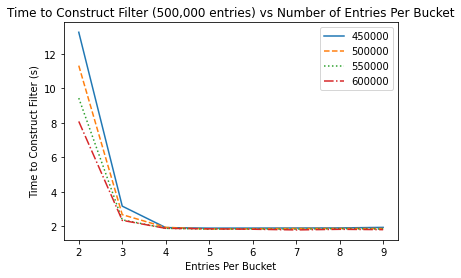

In [19]:
sizes = range(450000,650000,50000)
entries = range(2,10)
outputs = [[],[],[],[],[]]

index = 0
for size in sizes:
    for entry in entries:
        
        cf = ExtendedCuckooFilter(size, entry)

        with open('insert.txt', 'rt') as data_stream:
            start_time = time.time()
            for line in data_stream:
                for element in line.split():
                        cf.insert(element)
            end_time = time.time()

        outputs[index].append(round(end_time - start_time, 4))
    index += 1

# styles for line graph lines
line_styles = ["solid", "dashed", "dotted", "dashdot"]

for i in range(0,len(sizes)):
    plt.plot(entries, outputs[i], label=str(sizes[i]), linestyle=line_styles[i])

plt.title("Time to Construct Filter (500,000 entries) vs Number of Entries Per Bucket")
plt.xlabel("Entries Per Bucket")
plt.ylabel("Time to Construct Filter (s)")
plt.legend()

plt.show()

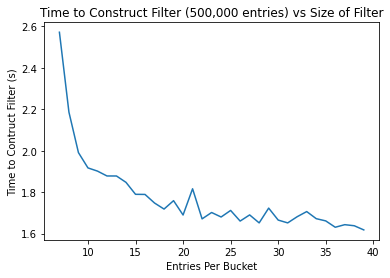

In [28]:
sizes = range(350000, 2000000, 50000)
outputs = []

for size in sizes:

    cf = ExtendedCuckooFilter(size, 4)

    with open('insert.txt', 'rt') as data_stream:
        start_time = time.time()
        for line in data_stream:
            for element in line.split():
                    cf.insert(element)
        end_time = time.time()

    outputs.append(round(end_time - start_time, 4))

# styles for line graph lines
line_styles = ["solid", "dashed", "dotted", "dashdot"]

bpe = []
for size in sizes:
    b = 500000 / size
    bpe.append((10/b))

plt.plot(bpe, outputs)

plt.title("Time to Construct Filter (500,000 entries) vs Size of Filter")
plt.xlabel("Entries Per Bucket")
plt.ylabel("Time to Contruct Filter (s)")

plt.show()